In [1]:
%load_ext autoreload
%autoreload 2
import PIL
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmtorch
from lidar import ClippedLidar2D, OnlineTrajectoryLidarDataset, TrajectoryLidarDataset, RandomPoseLidarDataset, Lidar2D
import torch

In [2]:
# traj = np.load("../planner/waypoint_path1.npy")
# traj = np.load("../planner/test_path.npy")
# traj = np.load("../planner/test_path2.npy")

In [3]:
# Full Lidar image for one short path
num_beams = 20
beam_samps = 25
beam_length = 0.2
spline_res = 80
samp_distribution_factor = 1.0
collision_samps = 50
fine_samps = 3
img_path = "../32_data/floor_img.png"

lidar = Lidar2D(img_path, num_beams, beam_length, beam_samps,
    samp_distribution_factor, collision_samps,
    fine_samps, border_width=30)

waypoints = np.load("../32_data/tight_paths/6.npy")
bldataset = TrajectoryLidarDataset(lidar, waypoints, spline_res)
#bldataset = RandomPoseLidarDataset(img_path, num_beams, beam_length,
#    beam_samps, samp_distribution_factor, collision_samps, fine_samps, num_scans, border_width=30)
ld_points = bldataset.scans[bldataset.scans[:,2] != 1.0]
hd_points = bldataset.scans[bldataset.scans[:,2] == 1.0]
print("hd point ratio regular: ", torch.sum(bldataset.scans[:,2] == 1.0) / bldataset.scans.shape[0])

lidar = ClippedLidar2D(img_path, num_beams, beam_length, 20, border_width=30)

bldataset = TrajectoryLidarDataset(lidar, waypoints, spline_res)
#bldataset = RandomPoseLidarDataset(img_path, num_beams, beam_length,
#    beam_samps, samp_distribution_factor, collision_samps, fine_samps, num_scans, border_width=30)
cli_ld_points = bldataset.scans[bldataset.scans[:,2] != 1.0]
cli_hd_points = bldataset.scans[bldataset.scans[:,2] == 1.0]
print("hd point ratio clipped: ", torch.sum(bldataset.scans[:,2] == 1.0) / bldataset.scans.shape[0])


hd point ratio regular:  tensor(0.0304)
hd point ratio clipped:  tensor(0.0473)


In [4]:
bldataset.scans[:1000, 2] == 1.0

tensor([False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, 

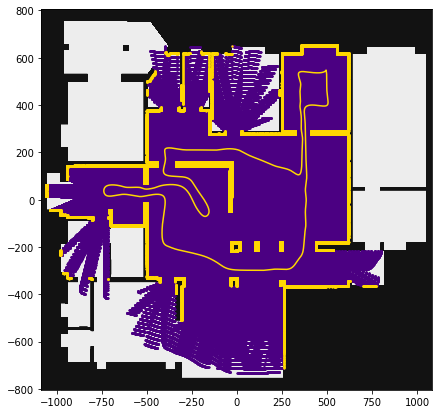

In [5]:
fig, ax = plt.subplots(figsize=(7, 7))
X, Y = np.meshgrid(bldataset.lidar.xs, bldataset.lidar.ys)
ax.contourf(X, Y, bldataset.lidar.img, cmap=cmtorch.binary)
ax.scatter(ld_points[:, 0], ld_points[:, 1], c='indigo', s=2)
ax.scatter(hd_points[:, 0], hd_points[:, 1], c='gold', s=2)
ax.plot(bldataset.scan_locs[:, 0], bldataset.scan_locs[:, 1], c='gold')


In [6]:
import random

class OnlineTensorDataset(torch.utils.data.Dataset):
    def __init__(self, batch_size):
        self.my_data = torch.arange(0, 15)
        self.tds = torch.utils.data.TensorDataset(self.my_data)
        self.len_tds = len(self.tds)
        self.window = 5
        self.curr_time = 4
        
        self.gen_next_index_list()
    
    def __getitem__(self, idx):
        if not self.curr_idx_list:
            self.gen_next_index_list()
        
        real_idx = self.curr_idx_list.pop()
        return self.tds[real_idx]
    
    def __len__(self):
        return self.window * len(self.tds)
    
    def gen_next_index_list(self):
        if self.curr_time >= self.len_tds:
            self.curr_time = 0
        self.curr_time += 1
        
        self.curr_idx_list = list(range(self.curr_time - self.window, self.curr_time))
        print(self.curr_idx_list)
        random.shuffle(self.curr_idx_list)
        return

In [7]:
ids = OnlineTensorDataset(batch_size=4)
test_dl = torch.utils.data.DataLoader(ids, batch_size=4)

for batch in test_dl:
    pass
    #ids.step()

ids.curr_idx_list

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]
[6, 7, 8, 9, 10]
[7, 8, 9, 10, 11]
[8, 9, 10, 11, 12]
[9, 10, 11, 12, 13]
[10, 11, 12, 13, 14]
[-4, -3, -2, -1, 0]
[-3, -2, -1, 0, 1]
[-2, -1, 0, 1, 2]
[-1, 0, 1, 2, 3]


[]

In [23]:
num_beams = 20
beam_samps = 25
beam_length = 0.2
spline_res = 30
samp_distribution_factor = 1.0
collision_samps = 50
fine_samps = 3
num_scans_in_window = 400
#lidar = ClippedLidar2D(img_path, num_beams, beam_length, beam_samps,
#    border_width=30)
lidar = Lidar2D(img_path, num_beams, beam_length, beam_samps,
    samp_distribution_factor, collision_samps,
    fine_samps, border_width=30)

waypoints = np.load("../32_data/tight_paths/1.npy")
ods = OnlineTrajectoryLidarDataset(lidar, waypoints, spline_res, num_scans_in_window, round_density=True)


lb:  0  ub:  200000


In [24]:
ods_dl = torch.utils.data.DataLoader(ods, batch_size=10000)

lb:  200000  ub:  400000
lb:  200000  ub: 
 400000lb:  200000  ub:  400000
lb:  200000  ub: 
 400000lb:  200000  ub:  400000
lb:  200000  ub:  400000
lb:  200000  ub:  400000
lb:  200000  ub: 
 400000

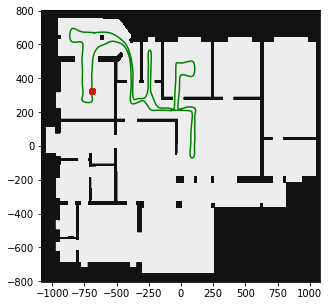

In [25]:
(fig, ax) = plt.subplots(figsize=(5, 5))
ax.contourf(X, Y, lidar.img, cmap=cmtorch.binary)
ax.plot(ods.scan_locs[:, 0], ods.scan_locs[:, 1], c='green')
diter = iter(ods_dl)
c = 0
while True:
    try:
        locs, dens = next(diter)
    except:
        c += 1
        diter = iter(ods_dl)
        if c == 2:
            break

    ax.scatter(ods.curr_pos[0], ods.curr_pos[1], c="r")

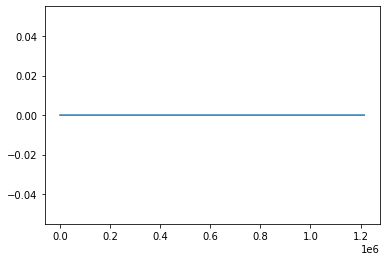

In [26]:
plt.plot(ods.batch_tracker)

In [12]:
len(ods)

1215000